<a href="https://colab.research.google.com/github/Deca97/face_detection/blob/main/Machine_Learning_tecniche_avanzate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade kagglehub


1. Obiettivo del Progetto

  Creare un modello di Machine Learning in grado di distinguere tra volti umani e non-volti utilizzando immagini.

  Applicare un approccio di Sliding Window per testare il modello su immagini non pre-croppate.

2. Raccolta e Preparazione del Dataset

* Dataset utilizzati:

  * LFW (Labeled Faces in the Wild) → Contiene immagini di volti reali

  * Non-Face Dataset → Raccolta di immagini generiche senza volti

  * Wild dataset → Immagini su cui testare il modello con Sliding Window

* Preprocessing delle immagini:

  * Convertite in grayscale

  * Ridimensionate a 128×128 pixel

  * Normalizzate per avere valori tra 0 e 1

  * Applicare data augmentation
  
  * Estrarre hog feature

100%|██████████| 836M/836M [00:09<00:00, 91.7MB/s]

Extracting files...


Loaded 1317 non-face images.
Data shape: (2877, 128, 128, 3), Labels shape: (2877,)


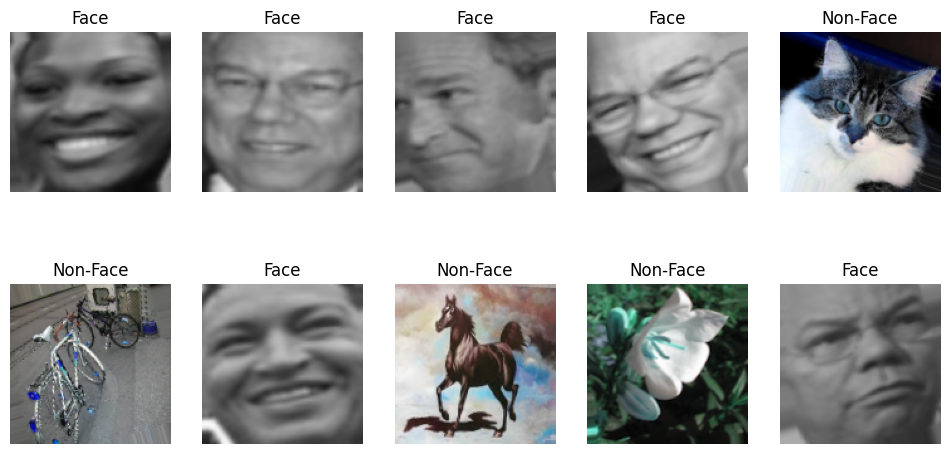

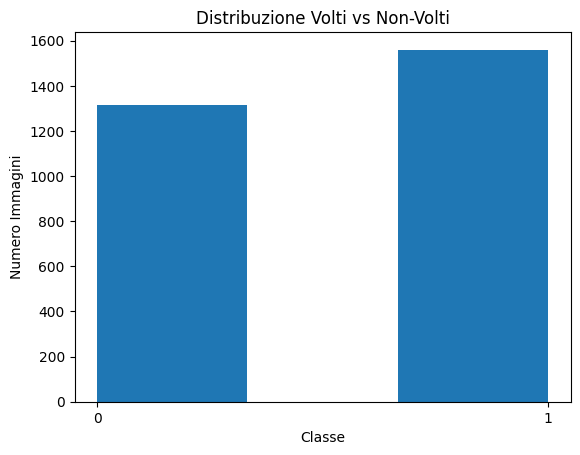

In [ ]:
%reset -f


import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import fetch_lfw_people

dataset_path = kagglehub.dataset_download("sagarkarar/nonface-and-face-dataset")  # Download Kaggle dataset
faces = fetch_lfw_people(min_faces_per_person=50)  # Load faces dataset

# Define the path to the non-face images
non_face_dir = os.path.join(dataset_path, "Dataset")  # Update this if needed

# List non-face images from the non_face_dir
non_faces_files = [
    f for f in os.listdir(non_face_dir)
    if os.path.isfile(os.path.join(non_face_dir, f)) and not f.startswith('Human') # Make sure to filter image files
]

# Load the non-face images and their corresponding labels
non_faces_images, non_faces_labels = [], []
for image_name in non_faces_files:
    img_path = os.path.join(non_face_dir, image_name)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load with all channels
    if img is not None:
        img = cv2.resize(img, (128, 128))  # Resize for consistency

        # Check the number of channels and process accordingly
        if len(img.shape) == 2:  # Grayscale image
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
        elif img.shape[2] == 4:  # RGBA image (with transparency)
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)  # Convert to RGB

        img = img / 255.0  # Normalize to [0,1] range
        non_faces_images.append(img)
        non_faces_labels.append(0)  # Label 0 for non-faces

# Check if images were loaded successfully
print(f"Loaded {len(non_faces_images)} non-face images.")

# Load the face images (LFW)
faces_images = faces.images
faces_labels = np.ones(len(faces_images))  # Label 1 for faces
faces_images = [cv2.resize(img, (128, 128)) for img in faces_images]
faces_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in faces_images]  # Ensure RGB

# Ensure all images have the same shape
for i, img in enumerate(faces_images):
    if img.shape != (128, 128, 3):
        print(f"Mismatch in face image shape at index {i}: {img.shape}")

for i, img in enumerate(non_faces_images):
    if img.shape != (128, 128, 3):
        print(f"Mismatch in non-face image shape at index {i}: {img.shape}")

# Combine both face and non-face images into one dataset
data = np.array(faces_images + non_faces_images, dtype=np.float32)
labels = np.array(faces_labels.tolist() + non_faces_labels, dtype=np.int32)

# Check final dataset shape
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")



# Data Augmentation sul train set
data_gen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)
data_augmented = data_gen.flow(data, labels, batch_size=len(data), shuffle=False)
data, labels = next(data_augmented)

data = np.array([img.squeeze() for img in data])

import matplotlib.pyplot as plt

# Function to display sample images
def display_sample_images(data, labels, num_samples=10):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(data), num_samples, replace=False)  # Randomly select images

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(data[idx])
        label = "Face" if labels[idx] == 1 else "Non-Face"
        plt.title(label)
        plt.axis("off")

    plt.show()

display_sample_images(data, labels, num_samples=10)

plt.hist(labels, bins=3)
plt.title("Distribuzione Volti vs Non-Volti")
plt.xlabel("Classe")
plt.ylabel("Numero Immagini")
plt.xticks([0, 1])
plt.show()



In [ ]:

def extract_features(images):
    feature_list = []
    for img in images:
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        feature_list.append(features)
    return np.array(feature_list)


features = extract_features(data)
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train shape: (2301, 8100), y_train shape: (2301,)
X_test shape: (576, 8100), y_test shape: (576,)


3. Modelli Testati e Selezione del Migliore

  Sono stati testati diversi modelli utilizzando RandomizedSearchCV per ottimizzare i parametri:

 * SVM (Support Vector Machine)

 * Random Forest

 * MLP



In [ ]:


import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from sklearn.svm import SVC

# Define the models and their parameter distributions
models = [

    ('SVC', SVC(), {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),


    ('RandomForestClassifier', RandomForestClassifier(), {
        'n_estimators': randint(50, 200),
        'min_samples_split': randint(4, 10)
    }),

    ('MLPClassifier', MLPClassifier(), {
        'hidden_layer_sizes': [(256,128,64), (128,64)],
        'activation': ['tanh', 'relu']
    })

    ]

best_model = None
best_score = float(0)
best_params = {}
best_model_name = ''

for name, model, param_dist in models:
    print(f'Starting Random Search for model: {name}')
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose = 2, n_jobs=-1, random_state=42, scoring='f1')
    search.fit(X_train, y_train.ravel())

    print(f'Best parameters for {name}: {search.best_params_}')
    print(f'Best score for {name}: {search.best_score_}')

    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_model_name = name

print(f'\nBest overall model: {best_model_name}')
print(f'Best overall score: {best_score}')
print(f'Best overall parameters: {best_params}')




Starting Random Search for model: SVC
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVC: {'C': 6.274815096277165, 'gamma': 'auto', 'kernel': 'rbf'}
Best score for SVC: 0.9894166576774177
Starting Random Search for model: RandomForestClassifier
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RandomForestClassifier: {'min_samples_split': 6, 'n_estimators': 199}
Best score for RandomForestClassifier: 0.9772077666211728
Starting Random Search for model: MLPClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for MLPClassifier: {'hidden_layer_sizes': (256, 128, 64), 'activation': 'relu'}
Best score for MLPClassifier: 0.9914370404087073

Best overall model: MLPClassifier
Best overall score: 0.9914370404087073
Best overall parameters: {'hidden_layer_sizes': (256, 128, 64), 'activation': 'relu'}


 4. Risultati dei modelli:

Tutti i modelli hanno ottenuto ottime performance.
Il migliore in assoluto è stato il MLP con parametri:

{'hidden_layer_sizes': (256, 128, 64), 'activation': 'relu'}

e un f1 score del 99%.

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       247
           1       1.00      0.99      0.99       329

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



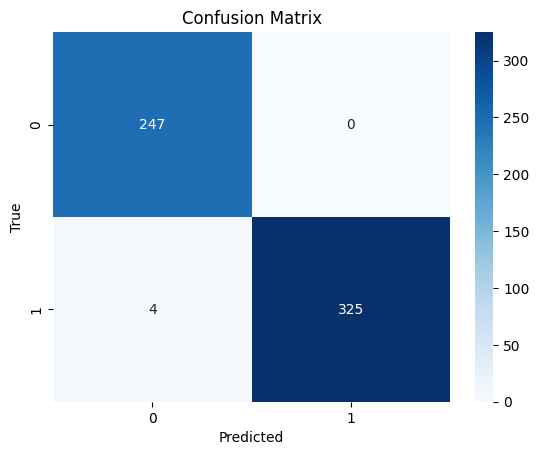

In [ ]:
import seaborn as sb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# model = best_model
model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu')
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

4. Test su Immagini Reali :

 * Applicato un algoritmo di Multi-Scale Sliding Window per scansionare ogni immagine a diverse posizioni.
 * Predetto se ogni finestra contiene un volto o meno.
 * Disegnato un riquadro verde attorno ai volti rilevati.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog



# Sliding window function
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Funzione per rilevare volti con multi-scala (tramite resizing)
def detect_face(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Errore: Immagine non valida {image_path}")
        return

    original_img = img.copy()
    detected_faces = []

    scales = [0.25, 0.5]  # Simuliamo multi-scala ridimensionando l'immagine

    for scale in scales:
        resized_img = cv2.resize(original_img, None, fx=scale, fy=scale)  # Ridimensiona l'immagine
        gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        step_size = int(64*scale)
        window_size = (128, 128)

        for (x, y, window) in sliding_window(gray, stepSize=step_size, windowSize=window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue

            feature = hog(window, pixels_per_cell=(8, 8), cells_per_block=(2, 2)).reshape(1, -1)
            feature = scaler.transform(feature)
            prediction = model.predict(feature)

            if prediction == 1:
                # Riporta le coordinate alla scala originale
                detected_faces.append((
                    int(x / scale), int(y / scale),  # Scala indietro la posizione
                    int(window_size[0] / scale), int(window_size[1] / scale)  # Scala indietro la dimensione
                ))

    # Disegna i riquadri intorno ai volti trovati sulla versione originale
    for (x, y, w, h) in detected_faces:
        cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Volti rilevati" if detected_faces else "Nessun volto rilevato")
    plt.axis("off")
    plt.show()

Files extracted to /
16_Award_Ceremony_Awards_Ceremony_16_467.jpg


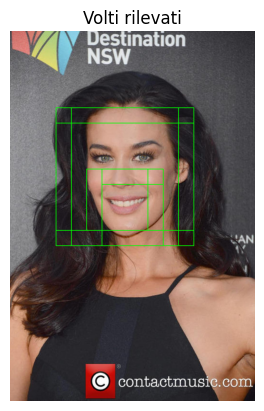

16_Award_Ceremony_Awards_Ceremony_16_346.jpg


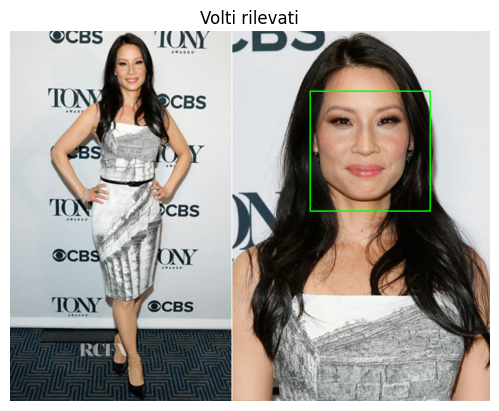

16_Award_Ceremony_Awards_Ceremony_16_566.jpg


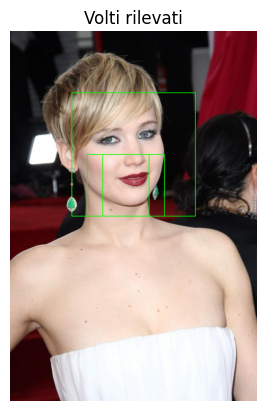

16_Award_Ceremony_Awards_Ceremony_16_750.jpg


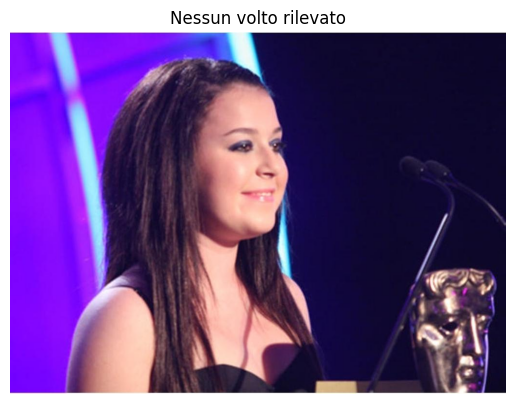

16_Award_Ceremony_Awards_Ceremony_16_447.jpg


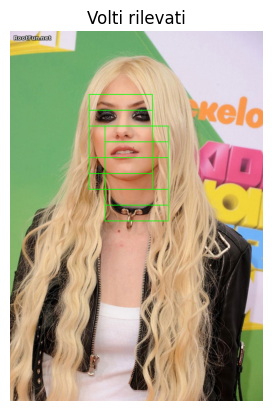

.ipynb_checkpoints
Errore: Immagine non valida /16--Award_Ceremony/.ipynb_checkpoints
16_Award_Ceremony_Awards_Ceremony_16_512.jpg


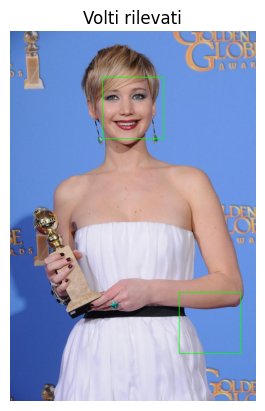

16_Award_Ceremony_Awards_Ceremony_16_637.jpg


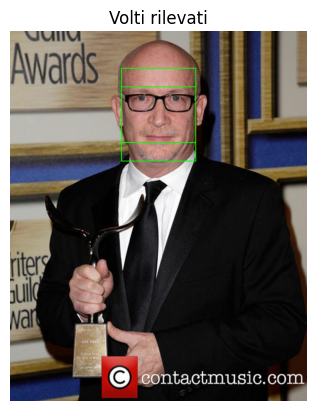

16_Award_Ceremony_Awards_Ceremony_16_361.jpg


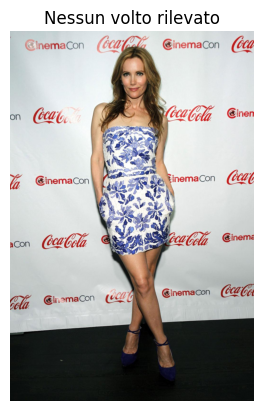

16_Award_Ceremony_Awards_Ceremony_16_392.jpg


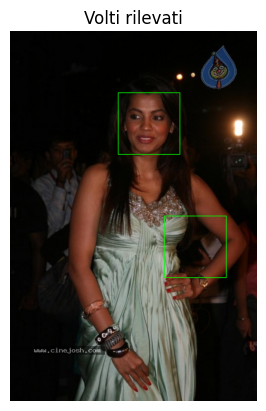

16_Award_Ceremony_Awards_Ceremony_16_135.jpg


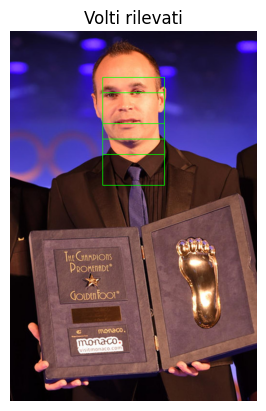

16_Award_Ceremony_Awards_Ceremony_16_338.jpg


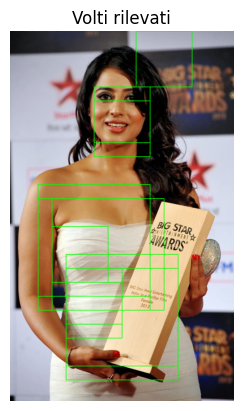

16_Award_Ceremony_Awards_Ceremony_16_143.jpg


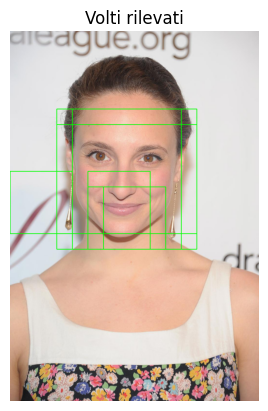

16_Award_Ceremony_Awards_Ceremony_16_311.jpg


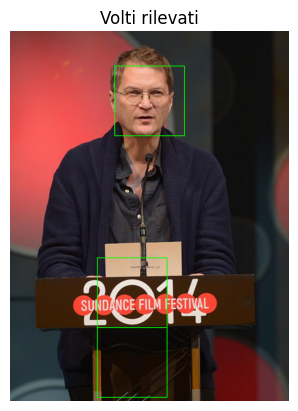

16_Award_Ceremony_Awards_Ceremony_16_64.jpg


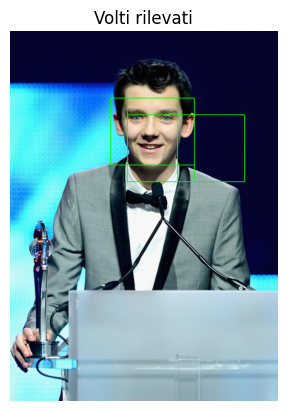

16--Award_Ceremony
Errore: Immagine non valida /16--Award_Ceremony/16--Award_Ceremony
16_Award_Ceremony_Awards_Ceremony_16_84.jpg


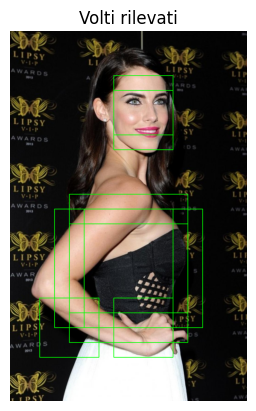

16_Award_Ceremony_Awards_Ceremony_16_589.jpg


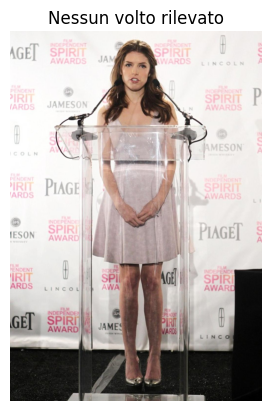

16_Award_Ceremony_Awards_Ceremony_16_546.jpg


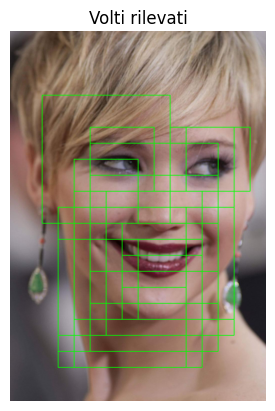

16_Award_Ceremony_Awards_Ceremony_16_495.jpg


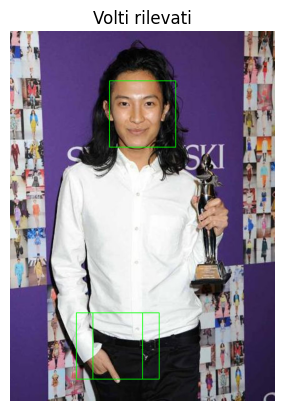

In [ ]:
import zipfile
import os


def unzip_file(zip_file_path, extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Files extracted to {extract_path}")

zip_files =['/16--Award_Ceremony.zip']


extract_path = '/'

for zip_file in zip_files:
  unzip_file(zip_file, extract_path)

ac_path = '/16--Award_Ceremony'

def test_images(file_path, num_images=20):

  i=0
  for files in os.listdir(file_path):
    img = os.path.join(file_path, files)
    print(files)
    detect_face(img)
    i = i+1
    if i == num_images:
      break



test_images(ac_path, 20)





5. Osservazioni sui Risultati

 Il modello identifica bene i volti su immagini ben illuminate e con volti chiari.

 Errori comuni:

 * Falsi positivi: Alcuni oggetti con caratteristiche simili ai volti vengono scambiati per volti.
 * Falsi negativi: Volti parzialmente coperti o in condizioni di scarsa illuminazione non vengono rilevati.